# 5. Pixel binning
<font size="4"> Perform pixel binning to get spatially resolved SEDs with sufficient S/N ratio. First, we will perform pixel binning on the photometric data cube, then apply it to the spectrophotometric data cube. The pixel binning scheme in **piXedfit** considers similarity in shape of the SEDs of individual pixels. In this scheme, the target S/N thresholds can be set to multiple bands, not limitied to a particular band. </font>     

In [1]:
import numpy as np
from astropy.io import fits
import os, sys
import matplotlib.pyplot as plt

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME)

%matplotlib inline

## 5.1. Pixel binning on photometric data cube
<font size="4"> This can be performed using `piXedfit.piXedfit_bin.pixel_binning_photo` function. In this example, we will achieve S/N>10 in GALEX and SDSS bands. 
</font>

In [2]:
from piXedfit.piXedfit_bin import pixel_binning_photo

In [3]:
#Recall our filters set:
filters = ['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 
           'sdss_z', '2mass_j', '2mass_h', '2mass_k', 'wise_w1', 'wise_w2']
nbands = len(filters)

In [11]:
flux_map_fits = "fluxmap_ngc309.fits"
ref_band = 4    # SDSS/r
Dmin_bin = 4    # in pixel
# Set S/N thresholds. Here we try S/N=10 in 5 SDSS bands
SNR = np.zeros(nbands)
for ii in range(0,7):
    SNR[ii] = 10.0 
name_out_fits = "pixbin_%s" % flux_map_fits
pixel_binning_photo(flux_map_fits=flux_map_fits, ref_band=ref_band, 
                    Dmin_bin=Dmin_bin, SNR=SNR, redc_chi2_limit=4.0, 
                    name_out_fits=name_out_fits)

[Pixel binning for fluxmap_ngc309.fits]
=> Number of pixels in the galaxy's region: 10185
=> Bin index=311  number of pixels in the bin=291  cumulative number of binned pixels=10185 


'pixbin_fluxmap_ngc309.fits'

<font size="4"> **Check result**: plot map of spatial bins.

In [4]:
hdu = fits.open("pixbin_fluxmap_ngc309.fits")
hdu.info()
header = hdu[0].header
print (header)

# get unit of flux:
unit = header['unit']

# get the data
bin_map = hdu['bin_map'].data
bin_flux = hdu['bin_flux'].data*unit
bin_fluxerr = hdu['bin_fluxerr'].data*unit
hdu.close()

Filename: pixbin_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   ()      
  1  BIN_MAP       1 ImageHDU         8   (131, 131)   float64   
  2  BIN_FLUX      1 ImageHDU         9   (131, 131, 12)   float64   
  3  BIN_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  NFILTERS=                   12                                                  HIERARCH nfilters_bin = 12                                                      REFBAND =                    4                                                  Z       =            0.0188977                                                  NBI

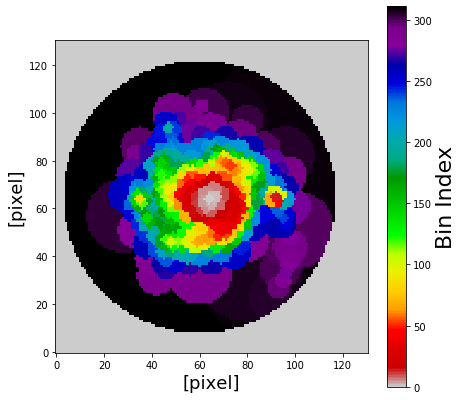

In [5]:
%matplotlib inline

# plot map of spatial bins
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
    
plt.imshow(bin_map, origin='lower', cmap='nipy_spectral_r')
cb = plt.colorbar()
cb.set_label(label='Bin Index', fontsize=22)

### How to get SEDs of individual bins?
<font size="4"> In the FITS file (extensions: 'BIN_FLUX' and 'BIN_FLUXERR'), the fluxes of spatial bins are painted on the pixels that belong to them. In other words pixels that belong to the same spatial bin have the same value, which is the flux of the bin itself.    </font>

/home/abdurrouf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


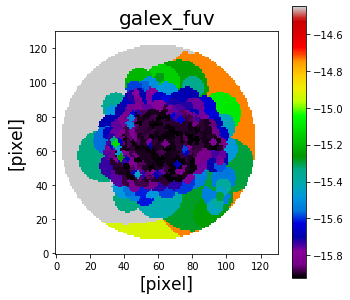

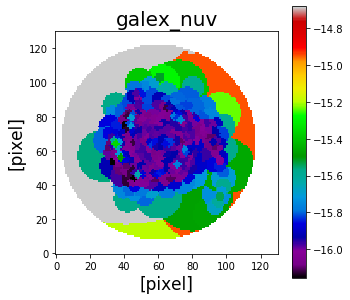

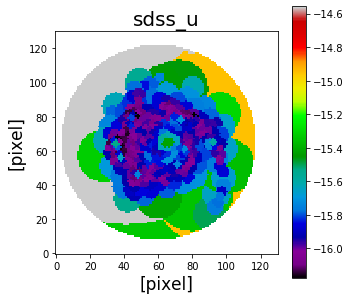

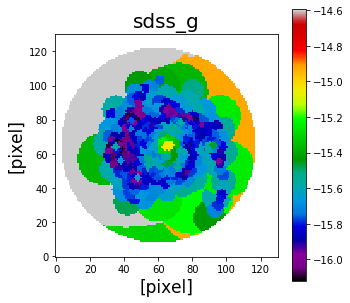

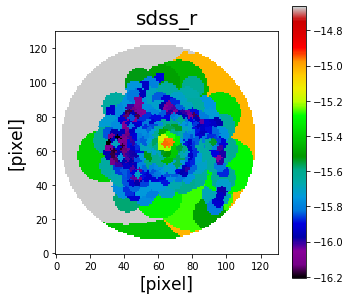

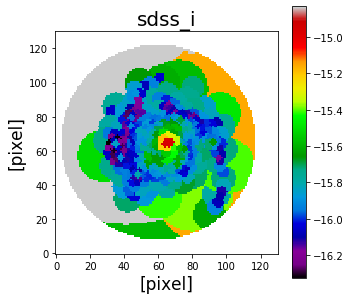

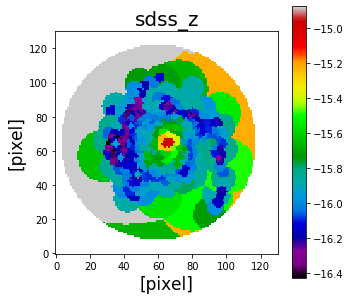

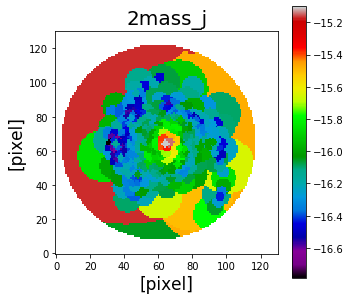

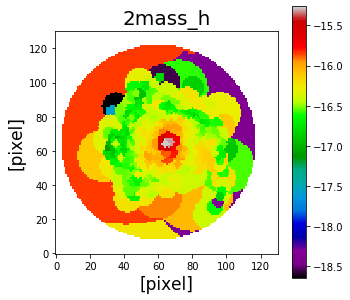

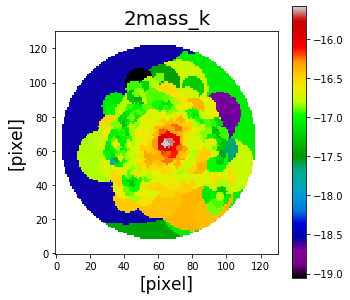

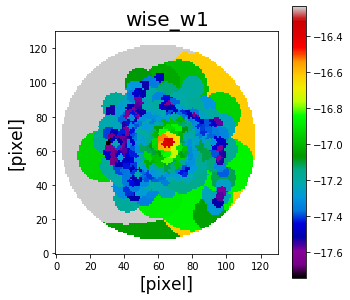

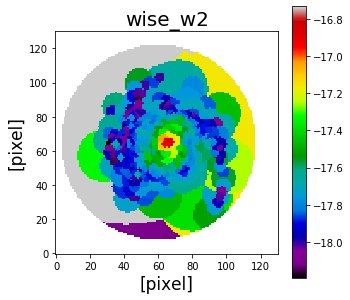

In [6]:
for bb in range(0,nbands):
    fig1 = plt.figure(figsize=(5,5))
    f1 = plt.subplot()
    plt.title("%s" % filters[int(bb)], fontsize=20)
    plt.xlabel("[pixel]", fontsize=17)
    plt.ylabel("[pixel]", fontsize=17)
    plt.imshow(np.log10(bin_flux[bb]), origin='lower', cmap='nipy_spectral')
    plt.colorbar()

<font size="4"> Get SEDs of spatial bins:

In [7]:
nbins = int(header['nbins'])

# transpose (band,y,x) => (y,x,band):
bin_flux_trans = np.transpose(bin_flux, axes=(1, 2, 0))
bin_fluxerr_trans = np.transpose(bin_fluxerr, axes=(1, 2, 0))

# get SEDs of individual spatial bins:
bin_SED_flux = np.zeros((nbins,nbands))
bin_SED_flux_err = np.zeros((nbins,nbands))
for ii in range(0,nbins):
    bin_idx = ii + 1                 # index of the spatial bin
    # get pixels that belong to this bin
    rows, cols = np.where(bin_map==bin_idx)
    
    # get the SED by copying from one of the pixel
    bin_SED_flux[ii] = bin_flux_trans[rows[0]][cols[0]]
    bin_SED_flux_err[ii] = bin_fluxerr_trans[rows[0]][cols[0]]

In [4]:
# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

<font size="4"> Plot SEDs of the first 50 spatial bins. </font>

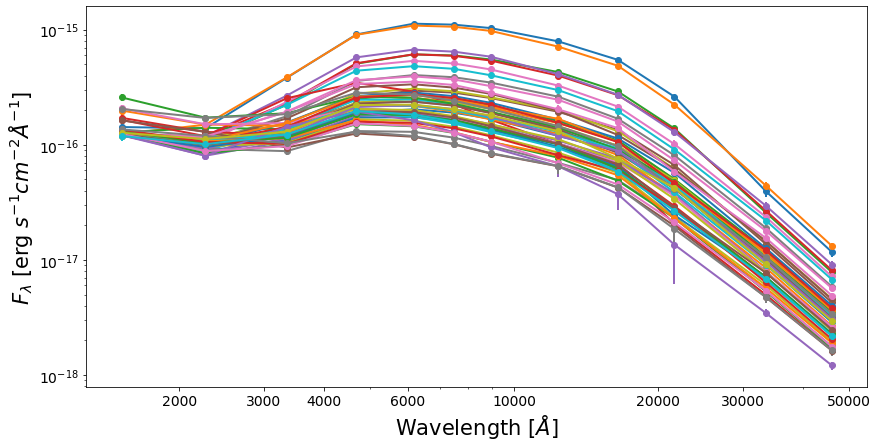

In [13]:
from matplotlib.ticker import ScalarFormatter

fig1 = plt.figure(figsize=(14,7))
f1 = plt.subplot()   
f1.set_yscale('log')
f1.set_xscale('log')
plt.setp(f1.get_yticklabels(), fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=14)
plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
plt.ylabel(r'$F_{\lambda}$ [erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)

xticks = [2000,3000,4000,6000,10000,20000,30000,50000]
plt.xticks(xticks)
for axis in [f1.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

for ii in range(0,50):
    plt.errorbar(photo_wave, bin_SED_flux[ii], 
                 yerr=bin_SED_flux_err[ii], fmt='-o', lw=2)

## 5.2. Pixel binning on spectrophotometric data cube
<font size="4"> Basically, the pixels are binned according to the map of the binned photometric data cube derived above. The selected spatial bins are those that all member pixels have both photometry and spectroscopy coverage. This can be performed using `piXedfit.piXedfit_bin.pixel_binning_specphoto` function.

In [5]:
from piXedfit.piXedfit_bin import pixel_binning_specphoto

In [6]:
specphoto_map_fits = "corr_specphoto_fluxmap_ngc309.fits"
fits_binmap = "pixbin_fluxmap_ngc309.fits" 
name_out_fits = "pixbin_%s" % specphoto_map_fits
pixel_binning_specphoto(specphoto_map_fits=specphoto_map_fits, fits_binmap=fits_binmap, 
                        name_out_fits=name_out_fits)

Number of photometric bins: 311
Number of spectroscopic bins: 138


'pixbin_corr_specphoto_fluxmap_ngc309.fits'

<font size="4"> **Check the result**: Maps of spatial bins and plot SEDs of some bins

In [9]:
cube = fits.open("pixbin_corr_specphoto_fluxmap_ngc309.fits")
cube.info()
print (cube[0].header)

# get data
header = cube[0].header
photo_bin_map = cube['photo_bin_map'].data
spec_bin_map = cube['spec_bin_map'].data
bin_photo_flux = cube['bin_photo_flux'].data
bin_photo_flux_err = cube['bin_photo_fluxerr'].data
spec_wave = cube['spec_wave'].data
bin_spec_flux = cube['bin_spec_flux'].data
bin_spec_flux_err = cube['bin_spec_fluxerr'].data
mod_wave = cube['mod_wave'].data
bin_mod_flux = cube['bin_mod_flux'].data

cube.close()

Filename: pixbin_corr_specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   ()      
  1  PHOTO_BIN_MAP    1 ImageHDU         8   (131, 131)   float64   
  2  SPEC_BIN_MAP    1 ImageHDU         8   (131, 131)   float64   
  3  BIN_PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  BIN_PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  SPEC_WAVE     1 ImageHDU         7   (1901,)   float64   
  6  BIN_SPEC_FLUX    1 ImageHDU         9   (131, 131, 1901)   float64   
  7  BIN_SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  8  MOD_WAVE      1 ImageHDU         7   (1553,)   float64   
  9  BIN_MOD_FLUX    1 ImageHDU         9   (131, 131, 1553)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / n

<font size="4"> Plot map of spatial bins that get IFS coverage.

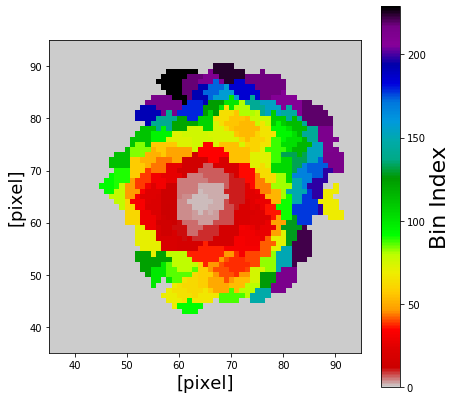

In [8]:
%matplotlib inline

x_cent = 65
y_cent = 65

## plot pixel binning map:
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
plt.xlim(x_cent-30,x_cent+30)
plt.ylim(y_cent-30,y_cent+30)

plt.imshow(spec_bin_map, origin='lower', cmap='nipy_spectral_r')
cb = plt.colorbar()
cb.set_label(label='Bin Index', fontsize=22)

In [12]:
nbins_photo = int(header['nbins_photo'])
nbins_spec = int(header['nbins_spec'])
unit = float(header['unit'])

dim_y = photo_bin_map.shape[0]
dim_x = photo_bin_map.shape[1]

# transpose (band,y,x) => (y,x,band):
bin_photo_flux_trans = np.transpose(bin_photo_flux, axes=(1, 2, 0))*unit
bin_photo_flux_err_trans = np.transpose(bin_photo_flux_err, axes=(1, 2, 0))*unit

# transpose (wave,y,x) => (y,x,wave)
bin_spec_flux_trans = np.transpose(bin_spec_flux, axes=(1, 2, 0))*unit
bin_spec_flux_err_trans = np.transpose(bin_spec_flux_err, axes=(1, 2, 0))*unit
bin_mod_flux_trans = np.transpose(bin_mod_flux, axes=(1,2,0))*unit

# get SEDs (spec+photo) of spatial bins
nwaves = len(spec_wave)
bin_photo_SED = np.zeros((nbins_photo,nbands))
bin_photo_SED_err = np.zeros((nbins_photo,nbands))
bin_spec_SED = np.zeros((nbins_photo,nwaves))
bin_spec_SED_err = np.zeros((nbins_photo,nwaves))
bin_mod_SED = np.zeros((nbins_photo,len(mod_wave)))

for yy in range(0,dim_y):
    for xx in range(0,dim_x):
        if photo_bin_map[yy][xx] > 0:
            bin_id = photo_bin_map[yy][xx] - 1
            bin_photo_SED[int(bin_id)] = bin_photo_flux_trans[yy][xx]
            bin_photo_SED_err[int(bin_id)] = bin_photo_flux_err_trans[yy][xx]
            
        if spec_bin_map[yy][xx] > 0:
            bin_id = spec_bin_map[yy][xx] - 1
            bin_spec_SED[int(bin_id)] = bin_spec_flux_trans[yy][xx]
            bin_spec_SED_err[int(bin_id)] = bin_spec_flux_err_trans[yy][xx]
            bin_mod_SED[int(bin_id)] = bin_mod_flux_trans[yy][xx]

<font size="4"> Plot SEDs of the first 20 spatial bins. </font>

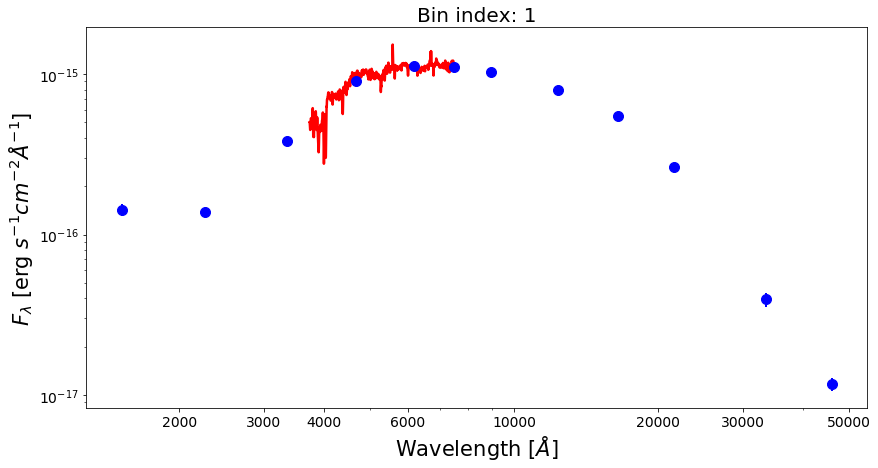

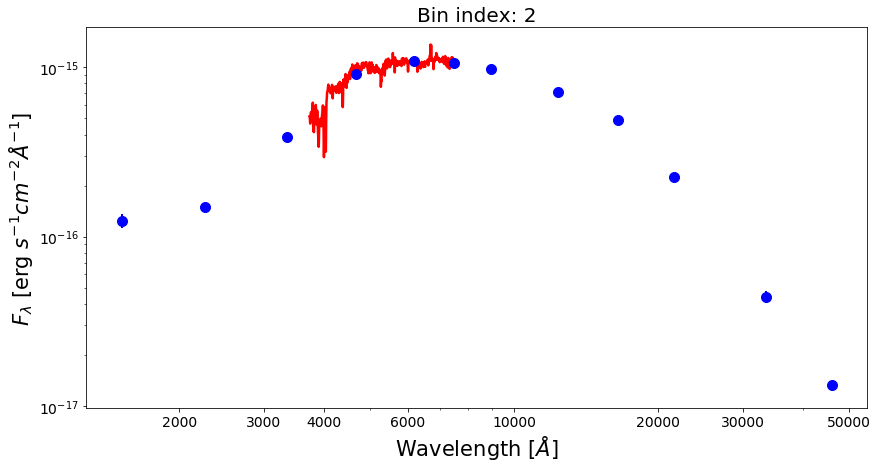

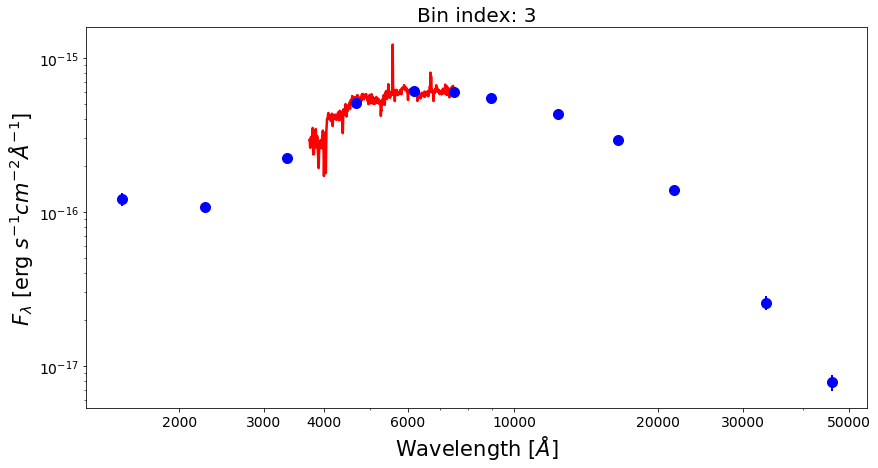

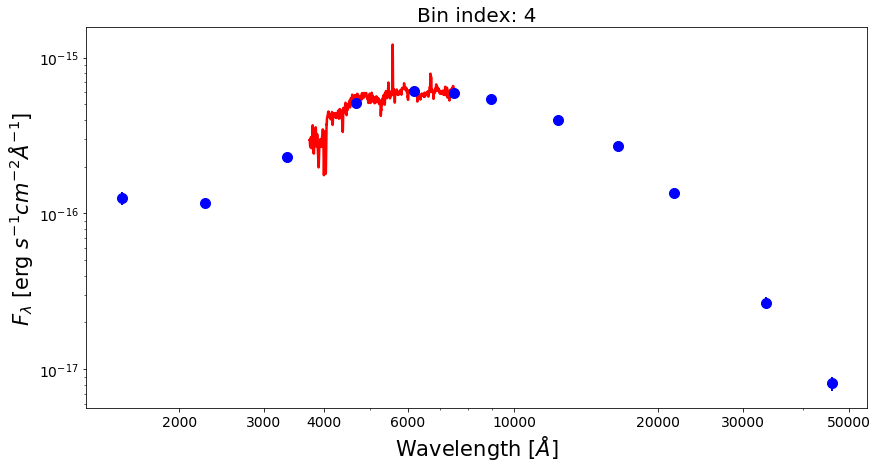

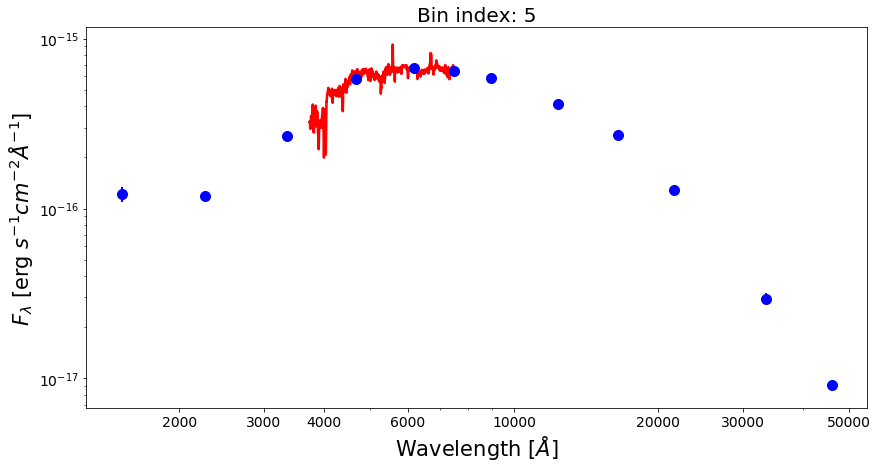

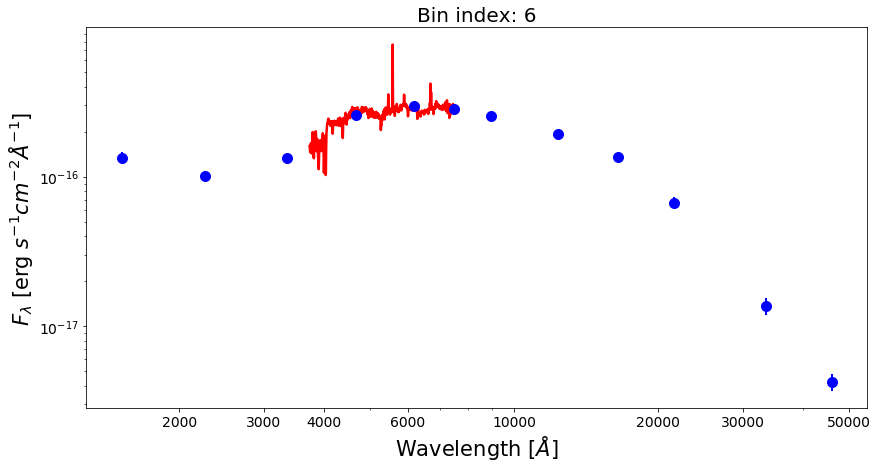

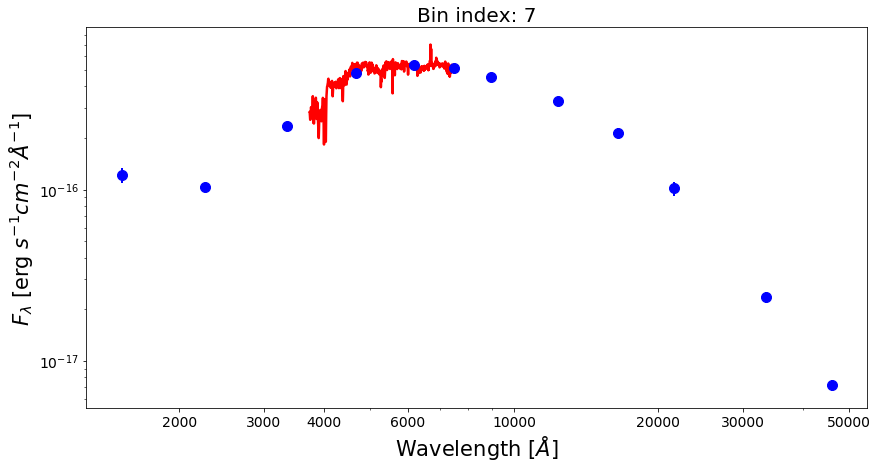

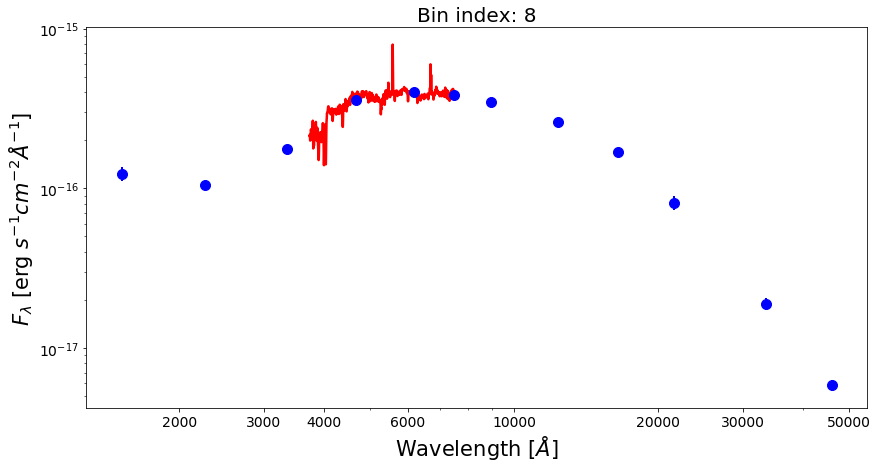

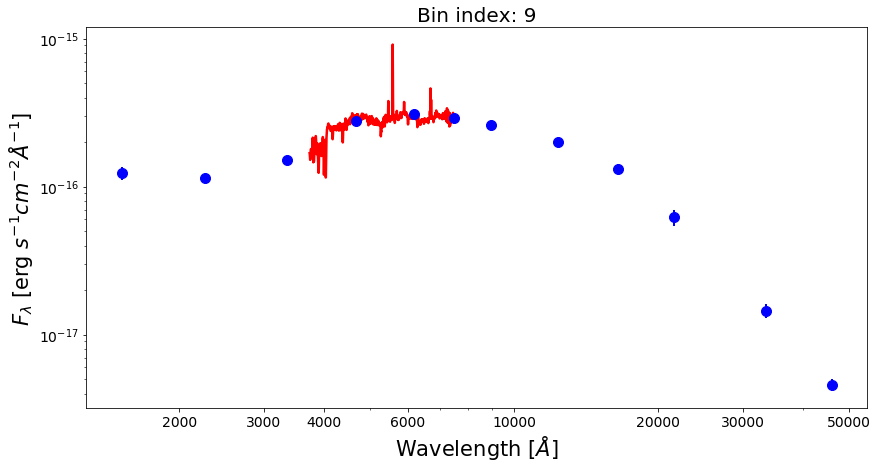

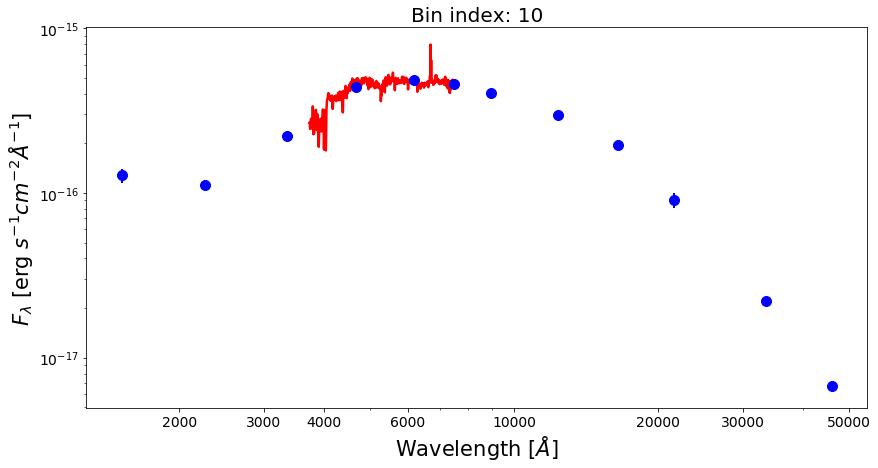

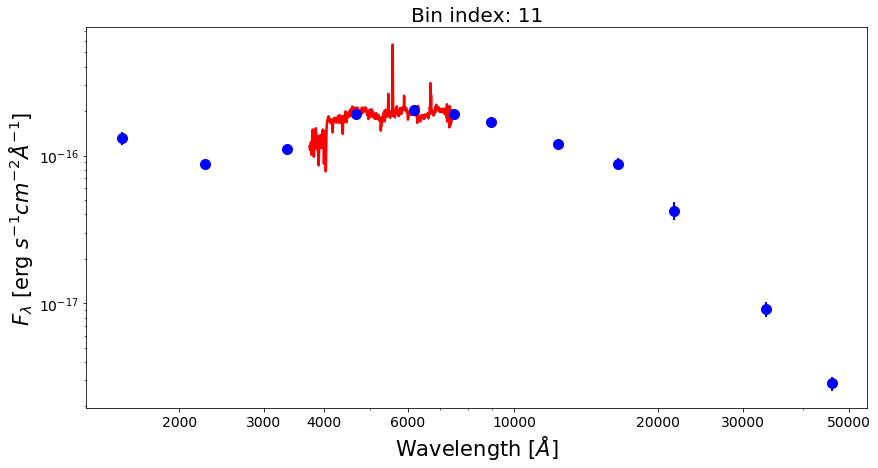

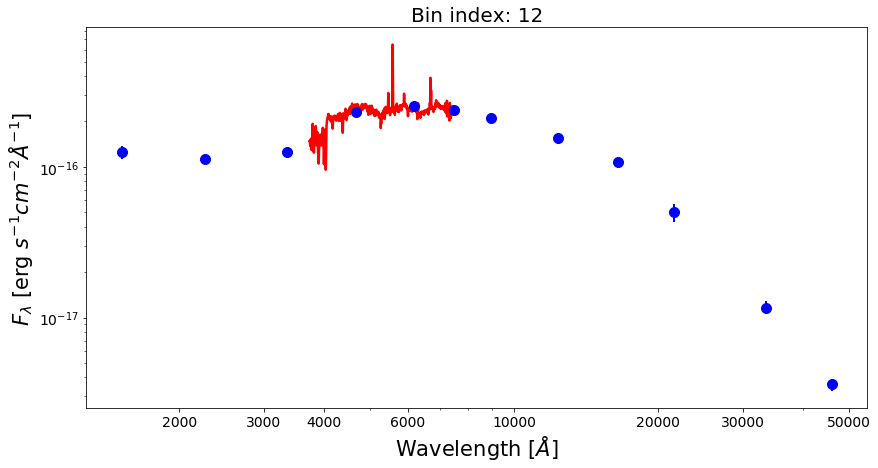

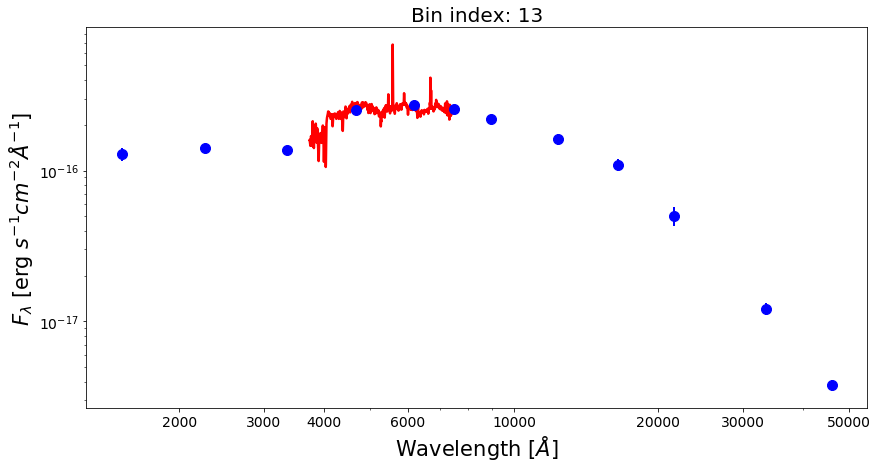

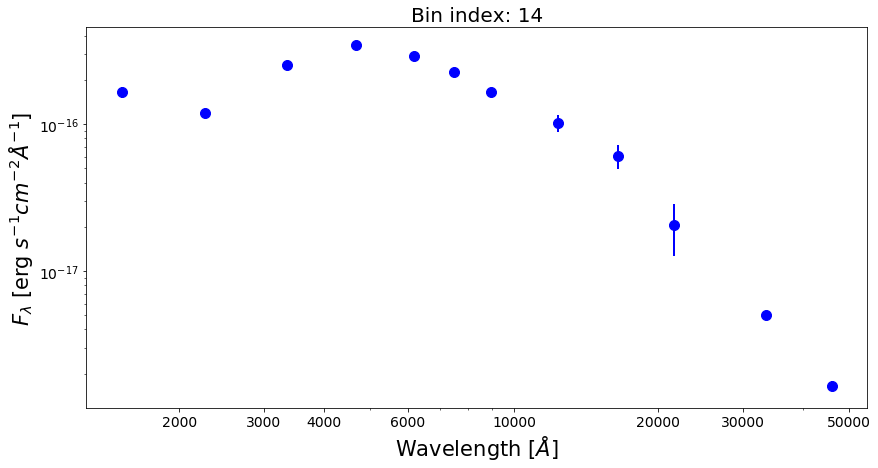

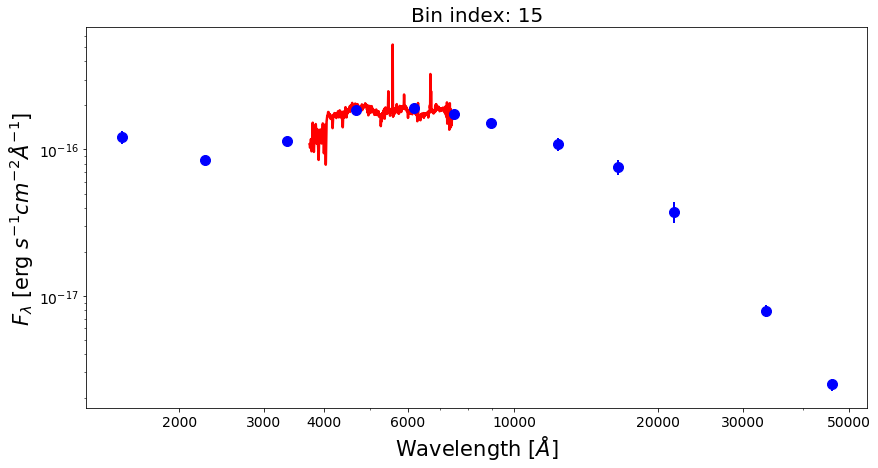

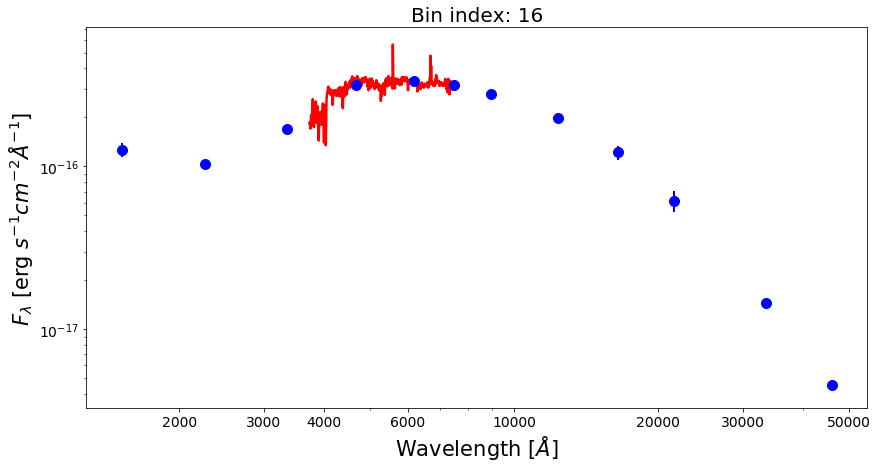

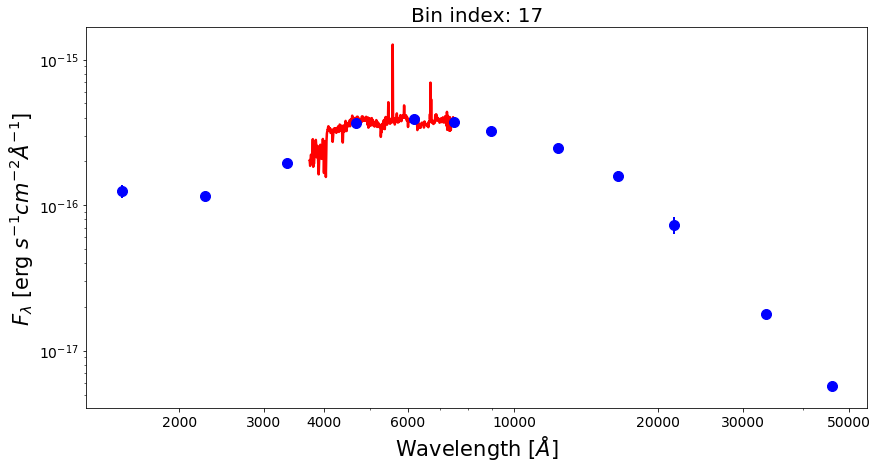

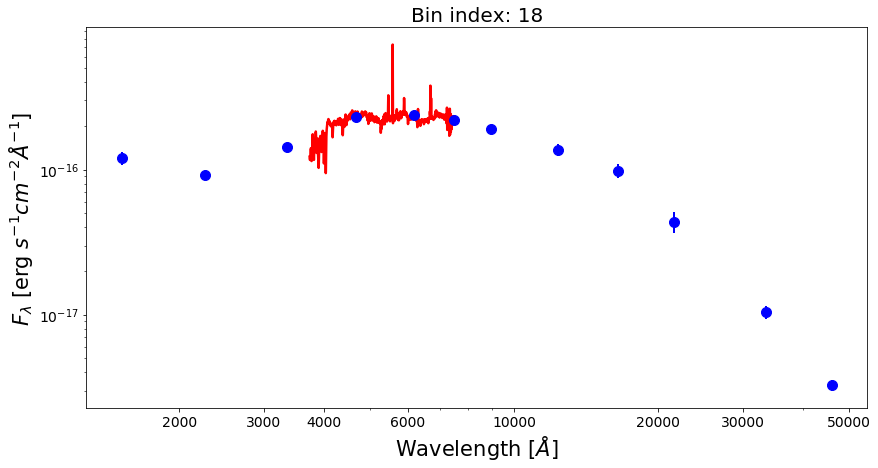

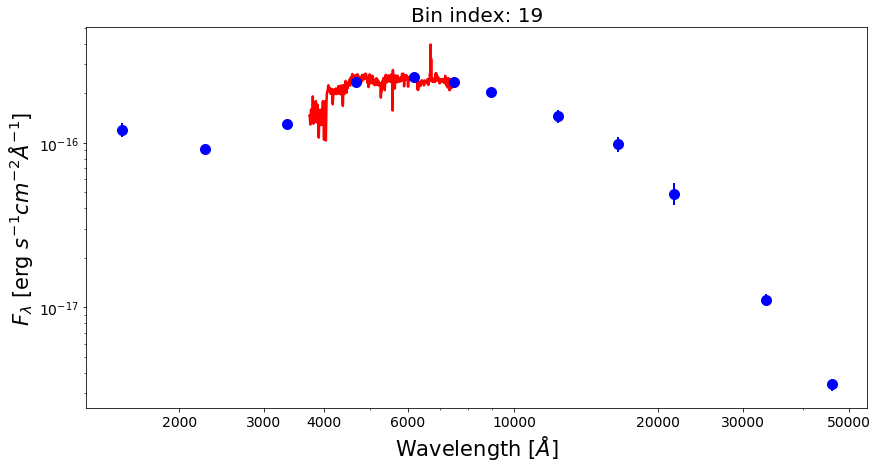

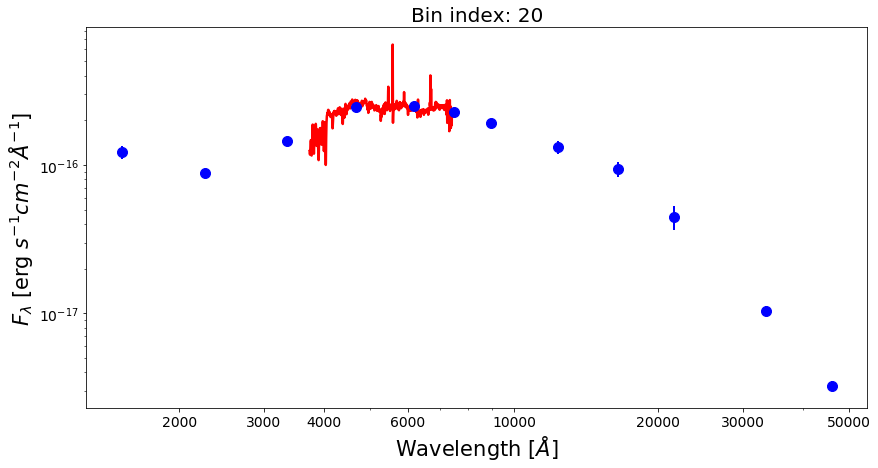

In [18]:
from matplotlib.ticker import ScalarFormatter

for ii in range(0,20):
    fig1 = plt.figure(figsize=(14,7))
    f1 = plt.subplot()   
    plt.title("Bin index: %d" % (ii+1), fontsize=20)
    f1.set_yscale('log')
    f1.set_xscale('log')
    plt.setp(f1.get_yticklabels(), fontsize=14)
    plt.setp(f1.get_xticklabels(), fontsize=14)
    plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
    plt.ylabel(r'$F_{\lambda}$ [erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
    xticks = [2000,3000,4000,6000,10000,20000,30000,50000]
    plt.xticks(xticks)
    #plt.xlim(3000,10000)
    #plt.ylim(6.5e-19,2e-16)
    for axis in [f1.xaxis]:
        axis.set_major_formatter(ScalarFormatter())

    if np.sum(bin_spec_SED[ii])>0:
        plt.plot(spec_wave[20:nwaves-20], bin_spec_SED[ii][20:nwaves-20], lw=2.5, color='red')
        
    plt.errorbar(photo_wave, bin_photo_SED[ii], yerr=bin_photo_SED_err[ii], markersize=10,
                            color='blue', fmt='o', lw=2)
    #if np.sum(bin_spec_SED[ii])>0:
    #    plt.plot(mod_wave, bin_mod_SED[ii], lw=0.5, color='black')